## Import the dependencies

In [1]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Download and visualize the dataset

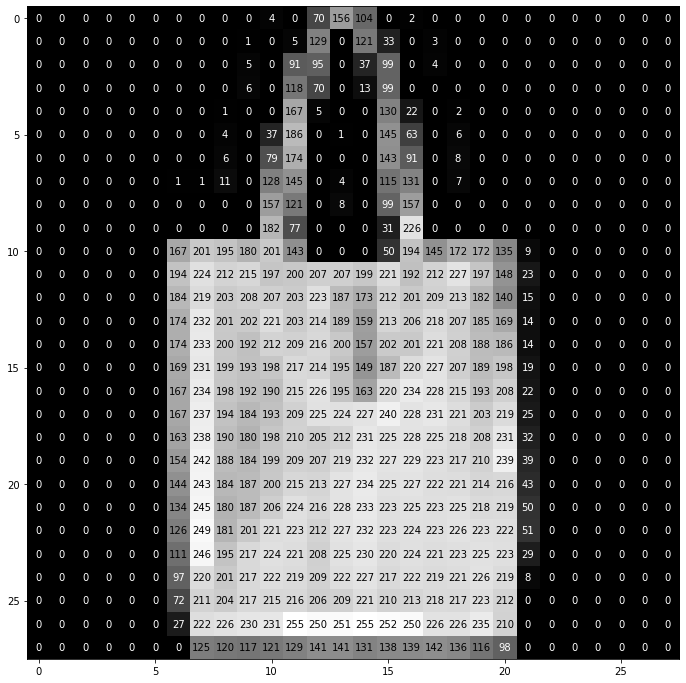

In [2]:
(training_data, _), (_, _) = fashion_mnist.load_data()
X_train = training_data / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

## Build the generator

In [3]:
def build_generator():
    generator = Sequential()
    generator.add(Dense(128 * 7 * 7, activation='relu', input_dim=100))
    generator.add(Reshape((7, 7, 128)))
    generator.add(UpSampling2D()) # 14 x 14

    generator.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(UpSampling2D()) # 28 x 28

    generator.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))

    generator.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

    generator.summary()

    noise = Input(shape=(100,))
    fake_image = generator(noise)
    return Model(inputs=noise, outputs=fake_image)

## Build the discriminator

In [4]:
def build_discriminator():
    discriminator = Sequential()

    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discriminator.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(28, 28, 1))
    probability = discriminator(img)

    return Model(inputs=img, outputs=probability)

## Build the combined model

In [13]:
# Input shape
img_shape = (28,28,1)
channels = 1
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)       

## Build the training function

In [14]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [15]:
def train(epochs, batch_size=128, save_interval=50):
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

0 [D loss: 1.086990, acc.: 40.62%] [G loss: 0.670598]
1 [D loss: 0.626777, acc.: 62.50%] [G loss: 0.710283]
2 [D loss: 0.476348, acc.: 73.44%] [G loss: 0.779349]
3 [D loss: 0.277380, acc.: 89.06%] [G loss: 0.889529]
4 [D loss: 0.176382, acc.: 95.31%] [G loss: 1.102937]
5 [D loss: 0.158536, acc.: 95.31%] [G loss: 0.917399]
6 [D loss: 0.163614, acc.: 96.88%] [G loss: 1.267412]
7 [D loss: 0.145817, acc.: 98.44%] [G loss: 1.148896]
8 [D loss: 0.076777, acc.: 100.00%] [G loss: 1.607877]
9 [D loss: 0.061769, acc.: 100.00%] [G loss: 1.705375]
10 [D loss: 0.064483, acc.: 98.44%] [G loss: 1.997154]
11 [D loss: 0.056517, acc.: 100.00%] [G loss: 2.367587]
12 [D loss: 0.079395, acc.: 100.00%] [G loss: 2.277383]
13 [D loss: 0.067925, acc.: 98.44%] [G loss: 2.714467]
14 [D loss: 0.055662, acc.: 100.00%] [G loss: 2.612455]
15 [D loss: 0.069932, acc.: 100.00%] [G loss: 2.329159]
16 [D loss: 0.065319, acc.: 100.00%] [G loss: 2.438729]
17 [D loss: 0.058151, acc.: 98.44%] [G loss: 2.188337]
18 [D loss: 0

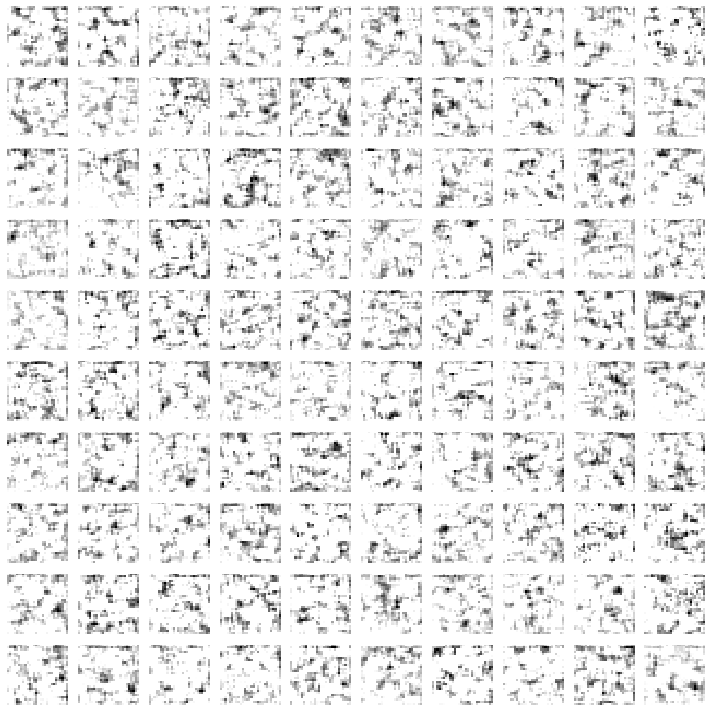

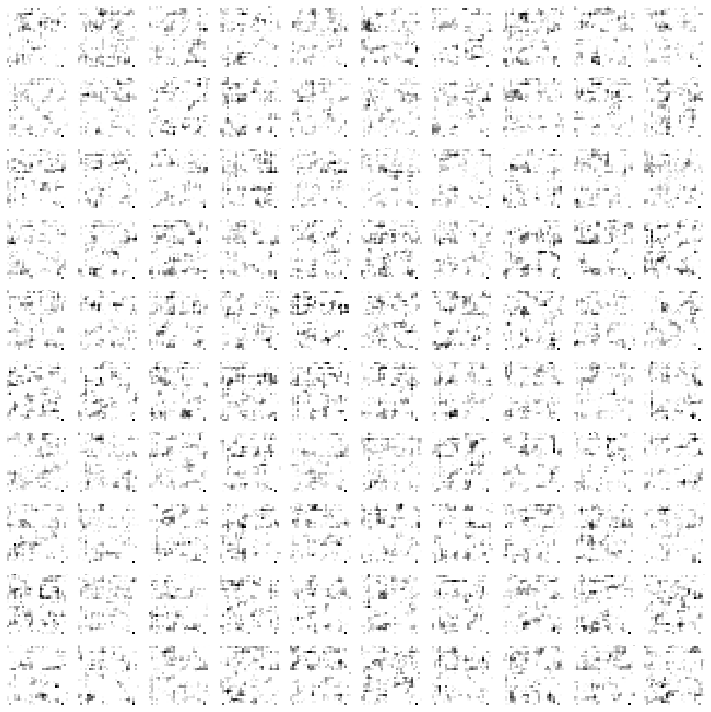

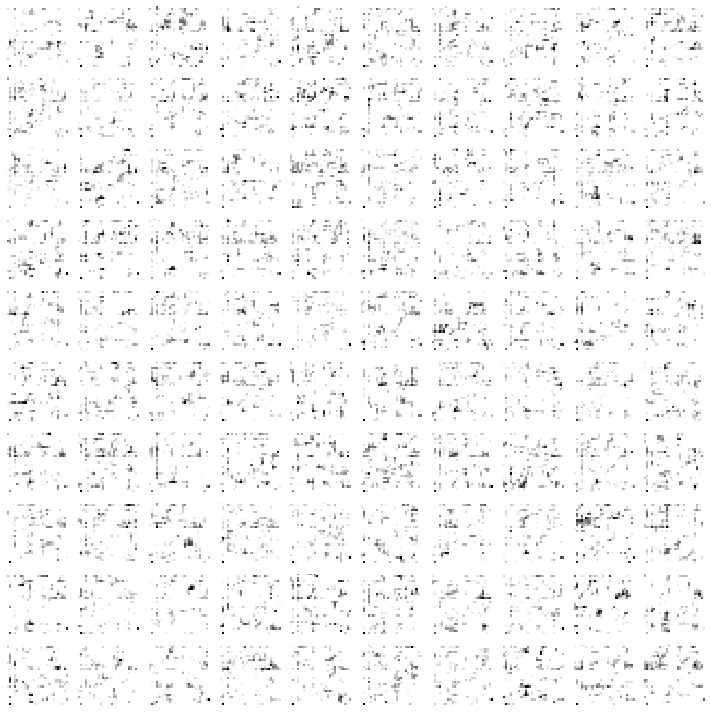

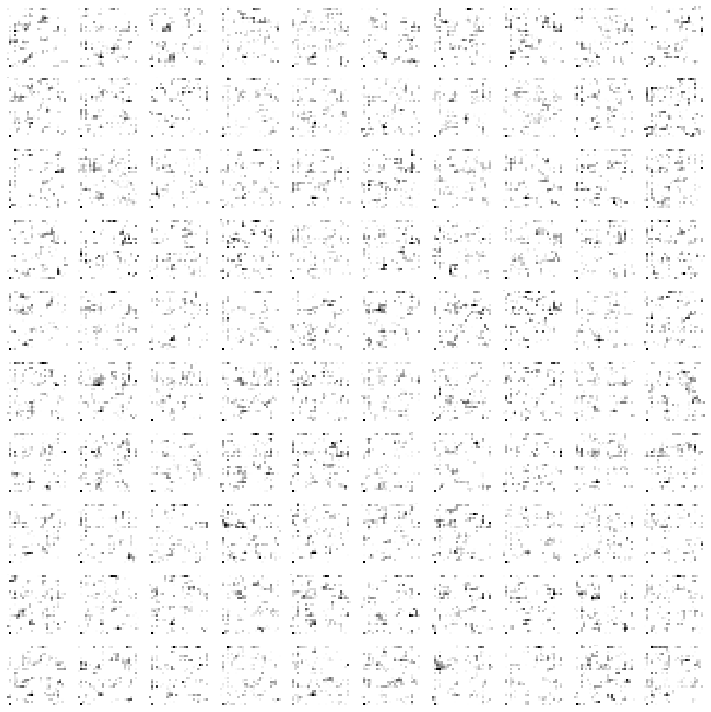

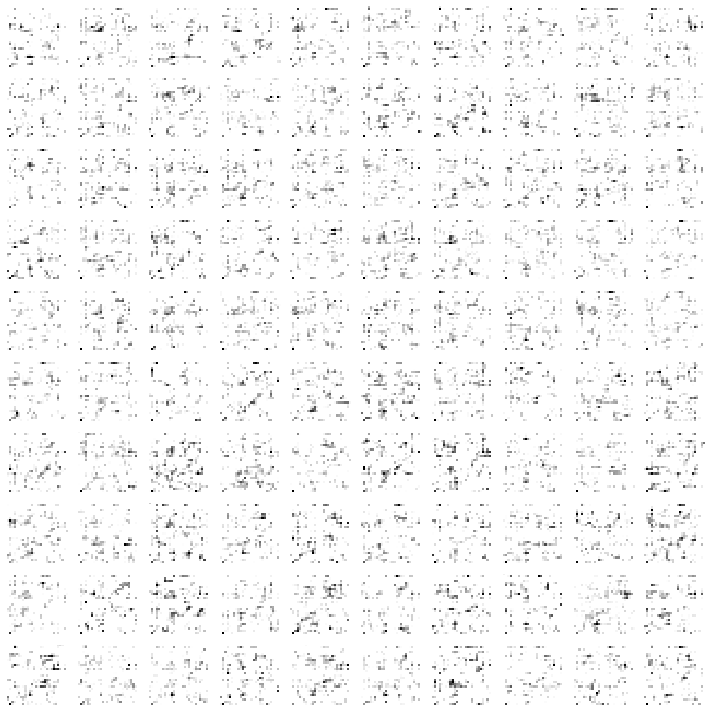

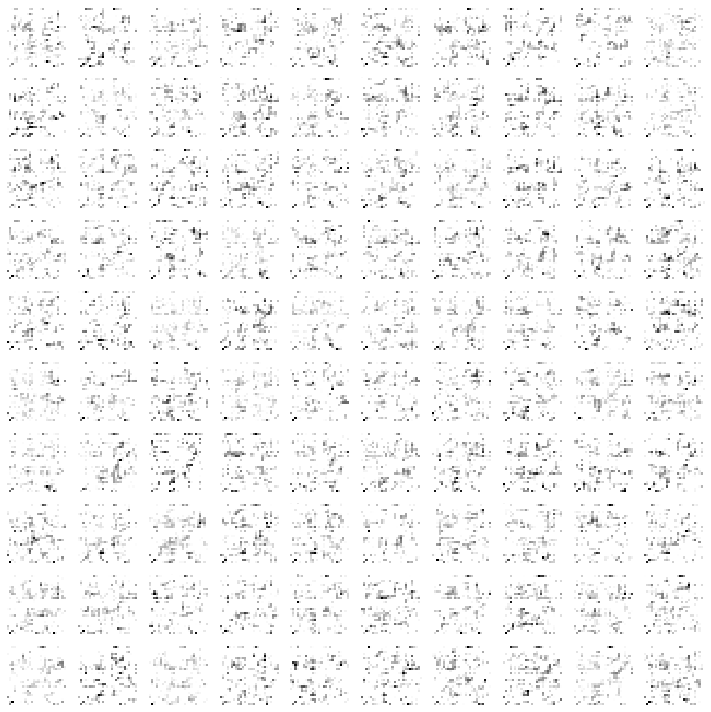

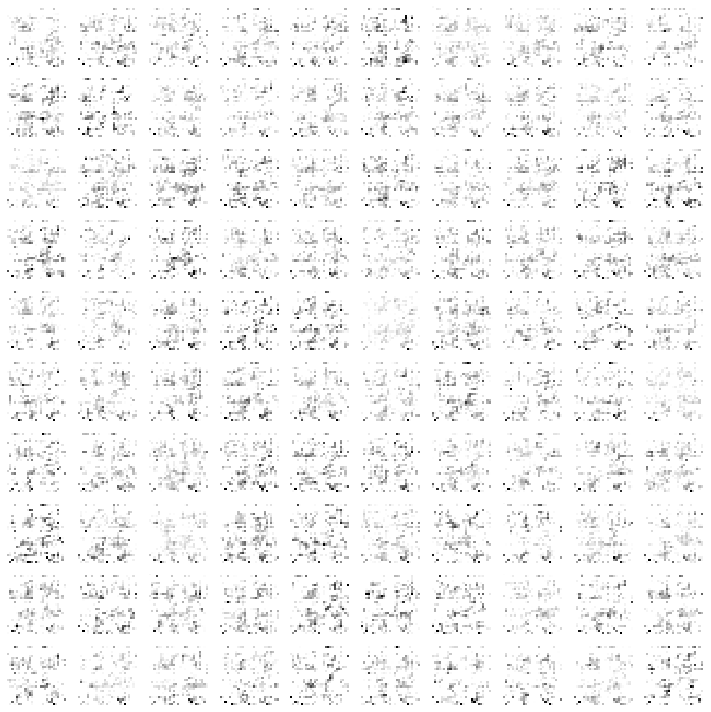

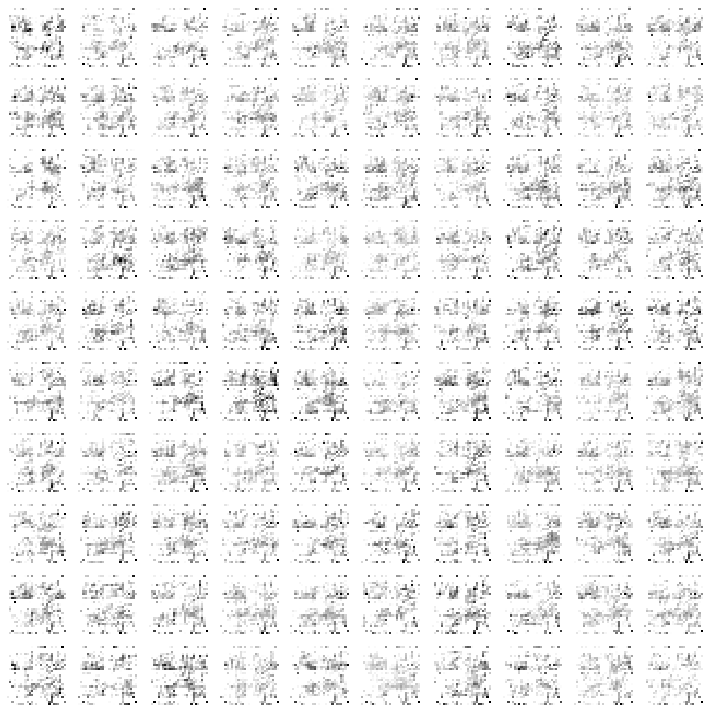

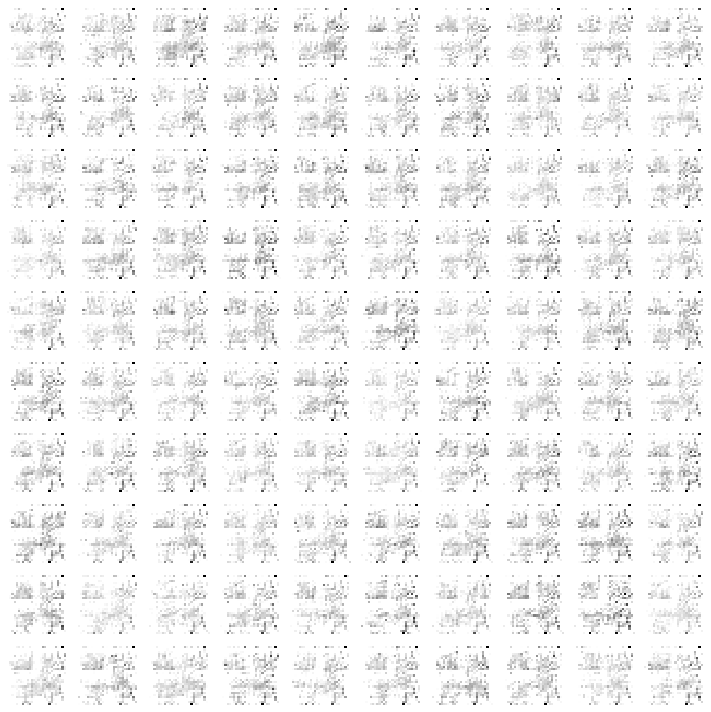

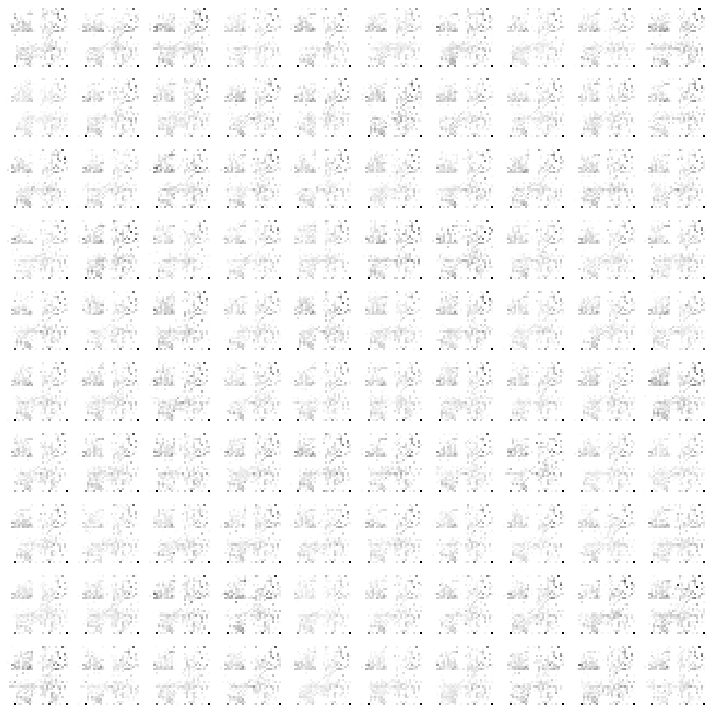

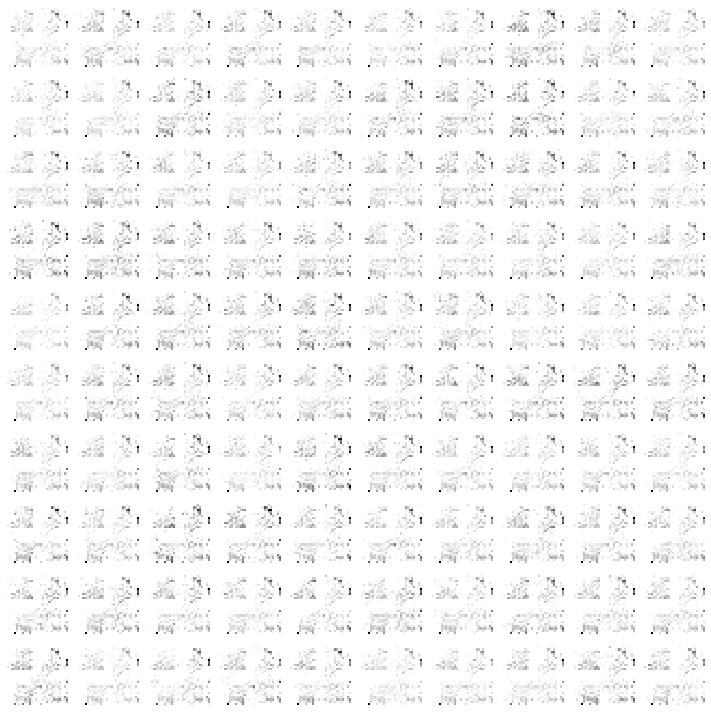

In [16]:
train(epochs=1001, batch_size=32, save_interval=100)

0 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.107933]
1 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.103042]
2 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.089351]
3 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.098273]
4 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.093495]
5 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.095041]
6 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.092594]
7 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.065236]
8 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.076187]
9 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.076030]
10 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.073524]
11 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.079746]
12 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.086435]
13 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.099209]
14 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.085461]
15 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.086439]
16 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.090135]
17 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.099471]
18

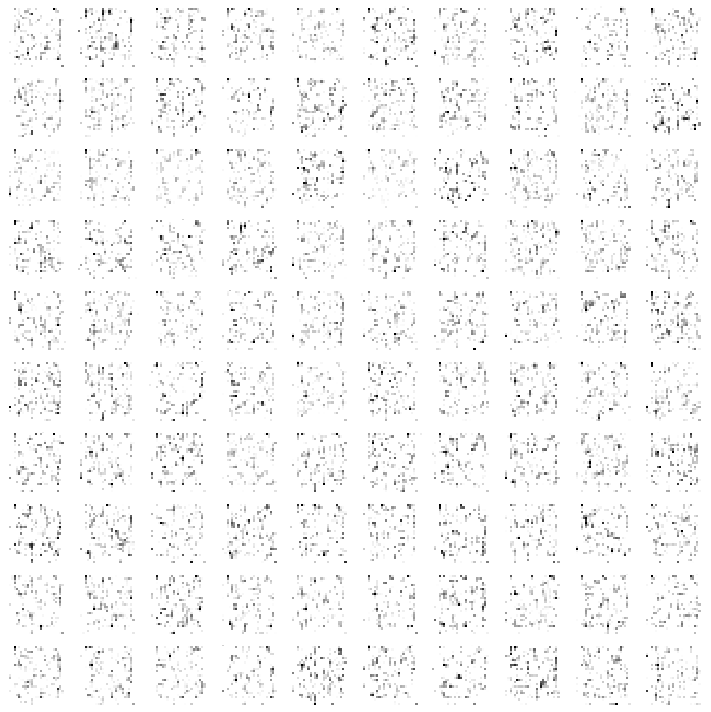

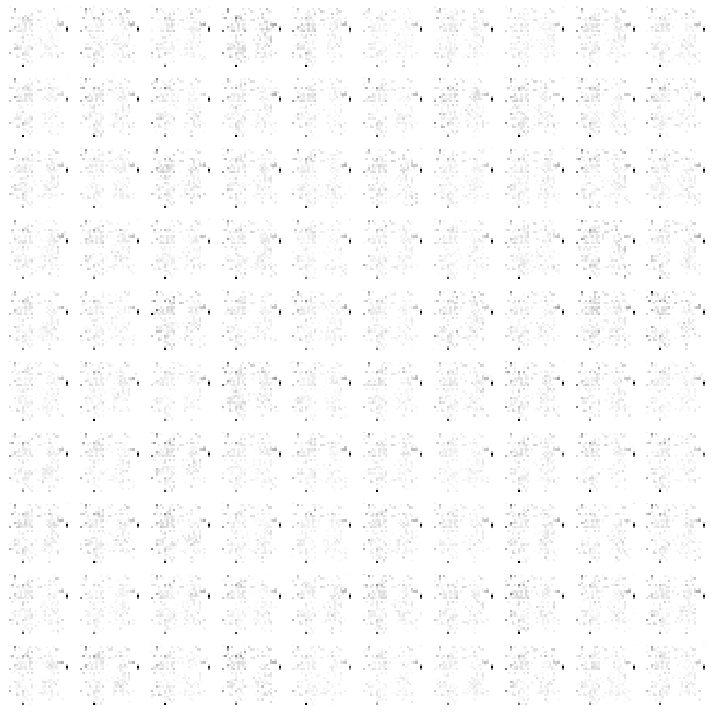

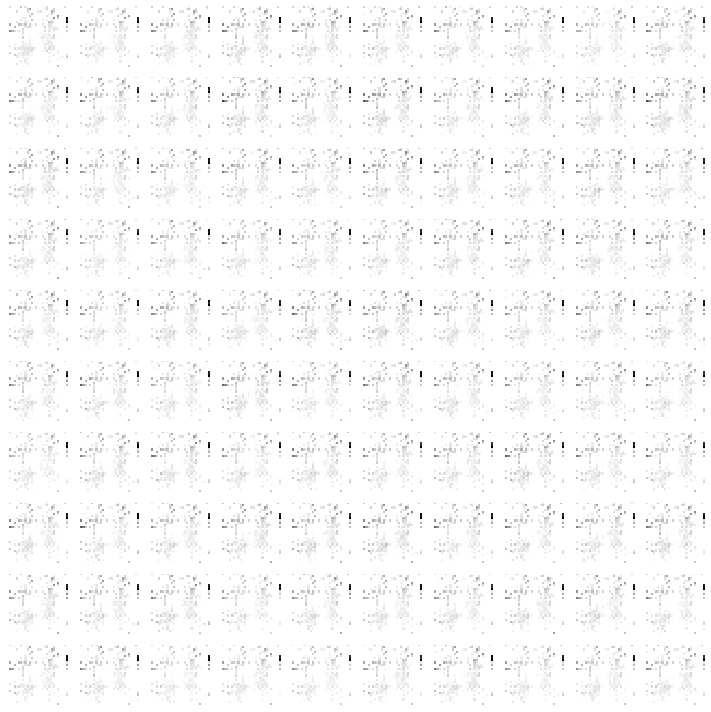

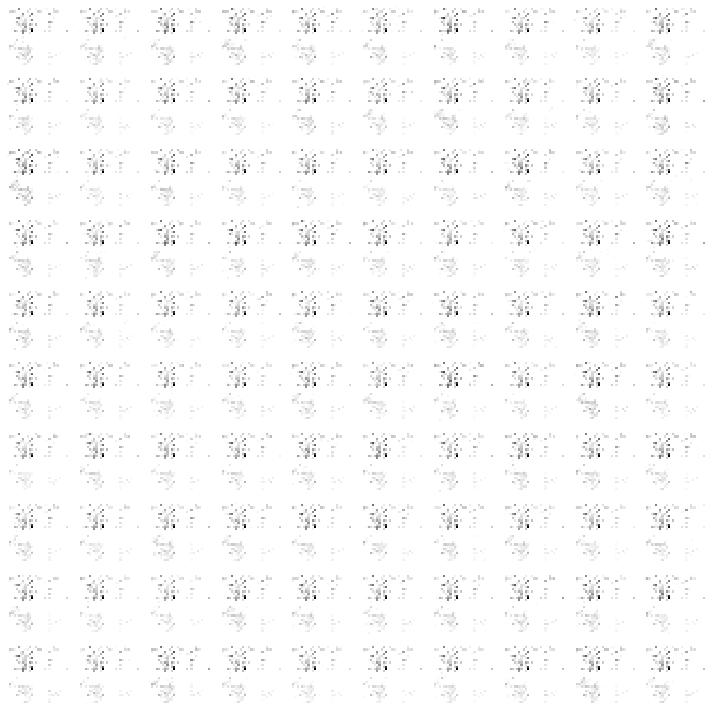

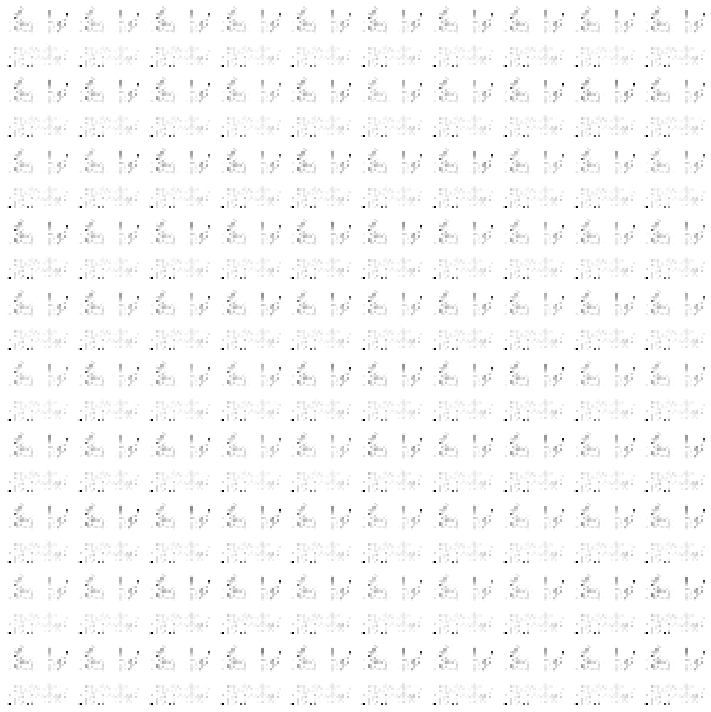

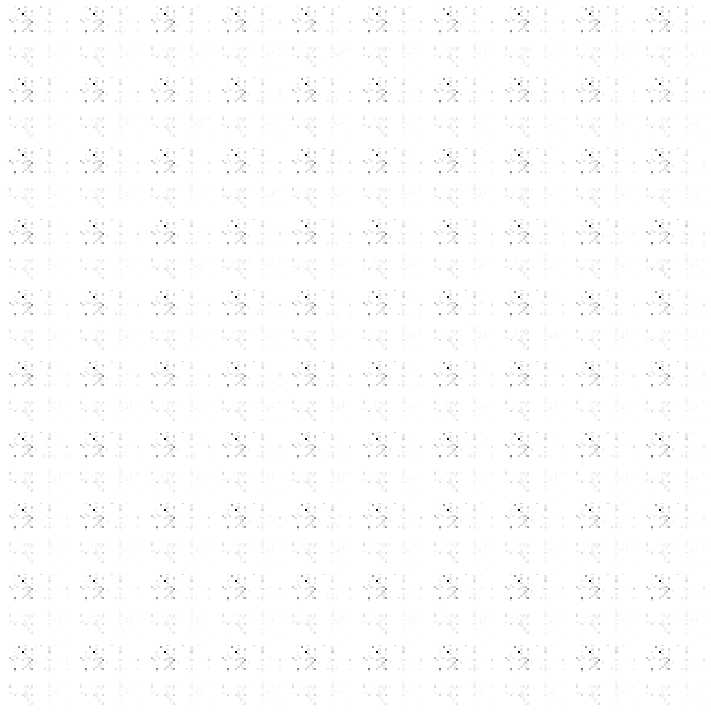

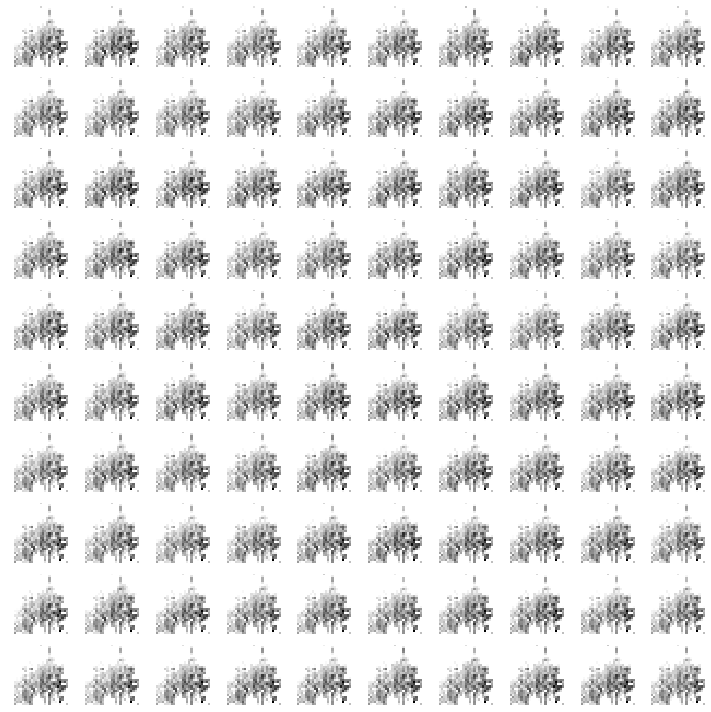

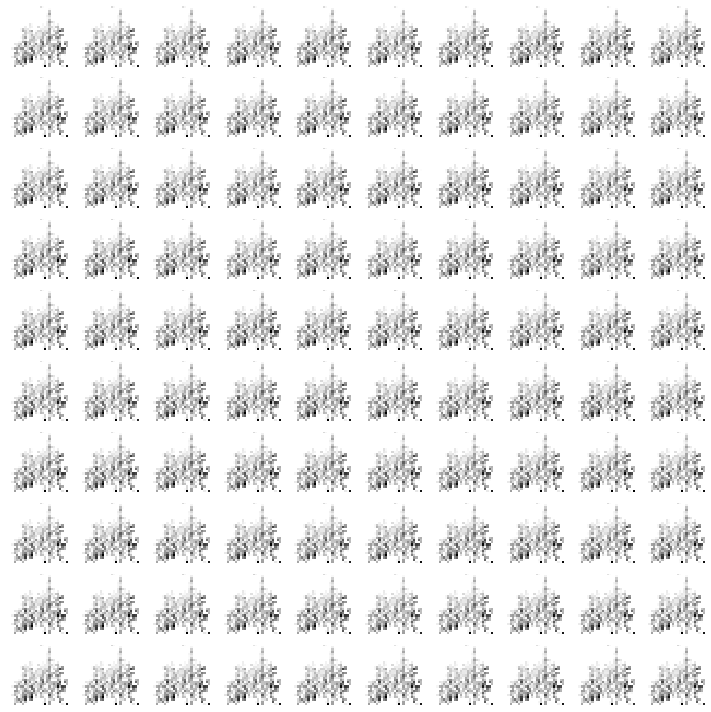

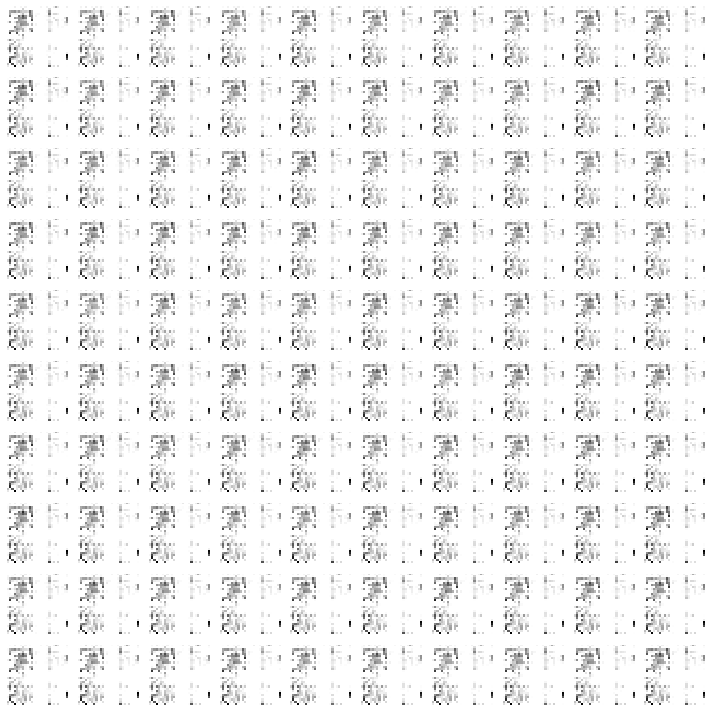

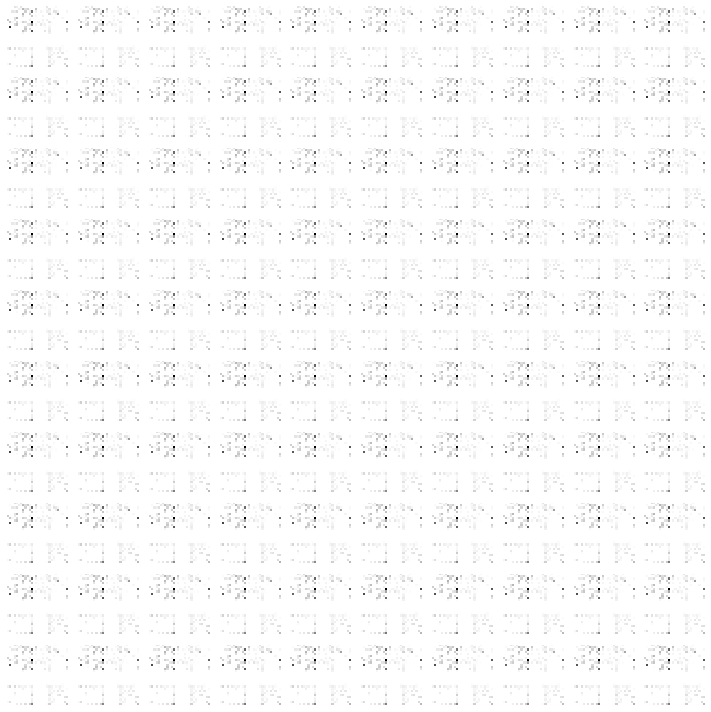

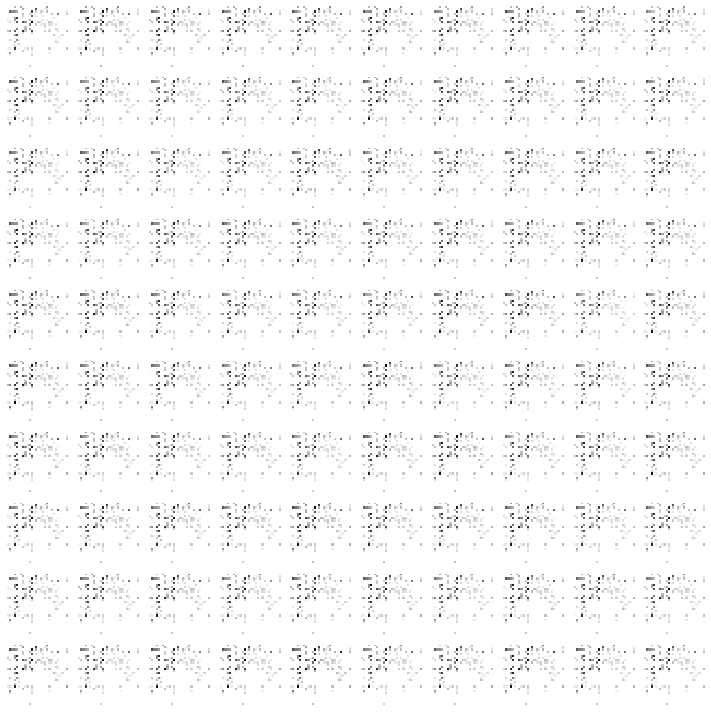

In [12]:
train(epochs=10001, batch_size=128, save_interval=1000)